<a href="https://colab.research.google.com/github/omar-khamis-dev/Sentiment_Analysis_DeepLearning/blob/main/notebooks/sentiment_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Sentiment Analysis – Deep Learning (Full dataset)**

This notebook trains and compares **LSTM/BiLSTM** and **DistilBERT** models on the large sentiment dataset (1.6M tweets). The data is loaded directly from the remote URL.

**Data loader**

In [ ]:
!pip install transformers datasets

In [1]:
%matplotlib inline

import pandas as pd
import requests, zipfile, io

url = "https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
df = pd.read_csv(z.open("training.1600000.processed.noemoticon.csv"), encoding="latin-1")

# Datast columns
df.columns = ["target", "ids", "date", "flag", "user", "text"]
df = df[["target", "text"]]

# Convert target from 0=negative, 4=positive
df["target"] = df["target"].replace({0:0, 4:1})

print(df.head())
print(df.shape)


ModuleNotFoundError: No module named 'matplotlib'

**Text cleaning (preprocessing)**

In [ ]:
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text) # Delete links
    text = re.sub(r"@\w+", "", text) # Delete mention
    text = re.sub(r"[^a-z\s]", "", text) # Delete symbols
    tokens = [w for w in text.split() if w not in stopwords.words("english")]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)
print(df["clean_text"].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    upset cant update facebook texting might cry r...
1    dived many times ball managed save rest go bounds
2                     whole body feels itchy like fire
3                             behaving im mad cant see
4                                           whole crew
Name: clean_text, dtype: object


**LSTM tokenization and model build**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Data processing
max_words = 30000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df["clean_text"])
sequences = tokenizer.texts_to_sequences(df["clean_text"])
X = pad_sequences(sequences, maxlen=max_len)
y = df["target"].values

# LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation="sigmoid")
])

model.build(input_shape=(None, max_len))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691,713 (10.27 MB)

 Trainable params: 2,691,713 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

None


**Model training**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=512)

loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/2
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2879s 1s/step - accuracy: 0.7557 - loss: 0.4945 - val_accuracy: 0.7897 - val_loss: 0.4464
Epoch 2/2
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2861s 1s/step - accuracy: 0.7983 - loss: 0.4309 - val_accuracy: 0.7928 - val_loss: 0.4410
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 425s 42ms/step - accuracy: 0.7925 - loss: 0.4409
Test Accuracy: 0.7933


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 420s 42ms/step


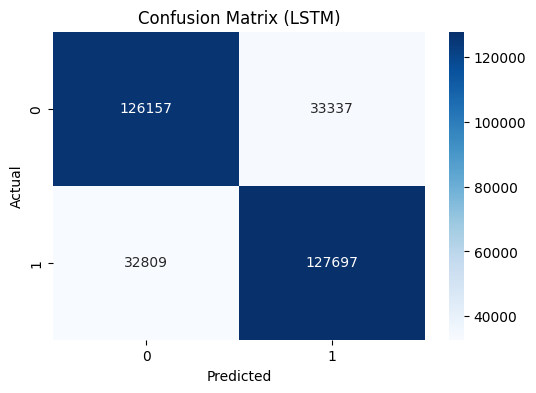

In [ ]:
# Prediction (Keras LSTM)
y_pred = model.predict(X_test)

# Convert probabilities to categories
y_pred = (y_pred > 0.5).astype(int).flatten()

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (LSTM)")
plt.show()


## **DistilBERT**

In [ ]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

# 1) Load data from the same source
texts = df['text'].tolist()
labels = df['target'].tolist()

# 2) Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# 3) Load DistilBERT's Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

**Model training**

In [ ]:
# 4) Convert data to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

# 5) Load a DistilBERT model designed for classification
model_bert = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(set(labels))
)

# 6) Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model_bert.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# 7) Train
history_bert = model_bert.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

In [ ]:
import matplotlib.pyplot as plt

lstm_acc = history_lstm.history['val_accuracy'][-1]
bert_acc = history_bert.history['val_accuracy'][-1]

print(f"LSTM Validation Accuracy: {lstm_acc:.4f}")
print(f"DistilBERT Validation Accuracy: {bert_acc:.4f}")

plt.bar(['LSTM', 'DistilBERT'], [lstm_acc, bert_acc], color=['blue', 'green'])
plt.title("Validation Accuracy Comparison")
plt.show()